<a href="https://colab.research.google.com/github/MasudRana2406/Integrating-Demand-Forecasting-and-Inventory-Optimization/blob/main/Integration_Retail_Demand_Forecasting_%26_Inventory_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Project Title:**

*Integrating Retail Demand Forecasting and Inventory Optimization to Enhance Supply Chain Efficiency*



### Import Required Libraries

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error


from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

### Load Dataset

In [ ]:
# Drive Mounting

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Check  files in folder

datasets_list = os.listdir('/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/m5-forecasting-accuracy')

for files in datasets_list:
  print(files)

sales_train_evaluation.csv
sell_prices.csv
sales_train_validation.csv
calendar.csv
sample_submission.csv


1. sales_train_validation.csv is the main dataset for time-series modelling which contains daily unit sales for each item–store combination.

2. sell_prices.csv contains historical prices for each item–store which is needed to understand price elasticity

3. calendar.csv contains date-level attributes such as events, SNAP, weekdays, month, year which useful for adding event features, capturing seasonality, understanding demand spikes.

4. Skipping sales_train_evaluation.csv and sample_submission.csv because they are competition-specific files not needed for training, validation, or analysis.

In [ ]:
# Load my required dateset

path = '/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/m5-forecasting-accuracy'


sales = pd.read_csv(os.path.join(path, 'sales_train_validation.csv'))
calendar = pd.read_csv(os.path.join(path, 'calendar.csv'))
prices = pd.read_csv(os.path.join(path, 'sell_prices.csv'))

print("Sales shape:", sales.shape)
print("Calendar shape:", calendar.shape)
print("Prices shape:", prices.shape)

Sales shape: (30490, 1919)
Calendar shape: (1969, 14)
Prices shape: (6841121, 4)


In [ ]:
# Check Sales dataset
sales.head(3)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1


In [ ]:
# Check DataFrame’s structure
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: int64(1913), object(6)
memory usage: 446.4+ MB


It’s a wide dataset with mostly numeric daily sales data and a few categorical identifiers.

In [ ]:
# Check Missing Values

missing_data = sales.isnull().sum()
missing_data[missing_data > 0]

,0


In [ ]:
# Check unique values in column except day column
for col in sales.columns:
  if not col.startswith('d_'):
    print(f"{col}: {sales[col].nunique()}")


id: 30490
item_id: 3049
dept_id: 7
cat_id: 3
store_id: 10
state_id: 3


In [ ]:
# Check statistical Summary
sales.describe()

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
count,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,...,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000
mean,1.070220,1.041292,0.780026,0.833454,0.627944,0.958052,0.918662,1.244080,1.073663,0.838701,...,1.370581,1.586159,1.693670,1.248245,1.232207,1.159167,1.149000,1.328862,1.605838,1.633158
std,5.126689,5.365468,3.667454,4.415141,3.379344,4.785947,5.059495,6.617729,5.917204,4.206199,...,3.740017,4.097191,4.359809,3.276925,3.125471,2.876026,2.950364,3.358012,4.089422,3.812248
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000
max,360.000000,436.000000,207.000000,323.000000,296.000000,314.000000,316.000000,370.000000,385.000000,353.000000,...,129.000000,160.000000,204.000000,98.000000,100.000000,88.000000,77.000000,141.000000,171.000000,130.000000


In [ ]:
# Check for duplicates

print(sales.duplicated().sum())

0


In [ ]:
# Check count the frequency of unique values of state_ID

sales['state_id'].value_counts()

,count
state_id,
CA,12196
TX,9147
WI,9147


In [ ]:
# Check count the frequency of unique values of store_id

sales['store_id'].value_counts()

,count
store_id,
CA_1,3049
CA_2,3049
CA_3,3049
CA_4,3049
TX_1,3049
TX_2,3049
TX_3,3049
WI_1,3049
WI_2,3049


In [ ]:
# Check count the frequency of unique values of cat_id

sales['cat_id'].value_counts()

,count
cat_id,
FOODS,14370
HOUSEHOLD,10470
HOBBIES,5650


In [ ]:
# Check count the frequency of unique values of dept_id

sales['dept_id'].value_counts()

,count
dept_id,
FOODS_3,8230
HOUSEHOLD_1,5320
HOUSEHOLD_2,5150
HOBBIES_1,4160
FOODS_2,3980
FOODS_1,2160
HOBBIES_2,1490


In [ ]:
# Check unique values

print(sales['state_id'].unique())
print(sales['store_id'].unique())
print(sales['cat_id'].unique())

['CA' 'TX' 'WI']
['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']
['HOBBIES' 'HOUSEHOLD' 'FOODS']


## Creating subset for demonstration

In [ ]:
# Creating subset by filtering to state, store, category

sales_subset = sales[(sales["state_id"] == "TX") & (sales["store_id"] == "TX_1") & (sales["cat_id"] == "FOODS")]
sales_subset.head(3)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
13808,FOODS_1_001_TX_1_validation,FOODS_1_001,FOODS_1,FOODS,TX_1,TX,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
13809,FOODS_1_002_TX_1_validation,FOODS_1_002,FOODS_1,FOODS,TX_1,TX,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
13810,FOODS_1_003_TX_1_validation,FOODS_1_003,FOODS_1,FOODS,TX_1,TX,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [ ]:
# Re-Check unique values in column except day column
for col in sales_subset.columns:
  if not col.startswith('d_'):
    print(f"{col}: {sales_subset[col].nunique()}")

id: 1437
item_id: 1437
dept_id: 3
cat_id: 1
store_id: 1
state_id: 1


## Transforming Sales Data: Wide to Long Format

In [ ]:
# Melt the sales data from wide (d_1, d_2…) to long format

id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
sales_long = pd.melt(sales_subset,id_vars=id_vars,var_name="d",value_name="sales")
sales_long.head(3)

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
0,FOODS_1_001_TX_1_validation,FOODS_1_001,FOODS_1,FOODS,TX_1,TX,d_1,0
1,FOODS_1_002_TX_1_validation,FOODS_1_002,FOODS_1,FOODS,TX_1,TX,d_1,0
2,FOODS_1_003_TX_1_validation,FOODS_1_003,FOODS_1,FOODS,TX_1,TX,d_1,0


In [ ]:
# Check data structure
sales_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2748981 entries, 0 to 2748980
Data columns (total 8 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   id        object
 1   item_id   object
 2   dept_id   object
 3   cat_id    object
 4   store_id  object
 5   state_id  object
 6   d         object
 7   sales     int64 
dtypes: int64(1), object(7)
memory usage: 167.8+ MB


In [ ]:
# Convert the "d" column (like "d_1", "d_2") into a numeric day index

sales_long["day_number"] = sales_long["d"].str.extract(r"_(\d+)").astype(int)
sales_long.head(3)

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,day_number
0,FOODS_1_001_TX_1_validation,FOODS_1_001,FOODS_1,FOODS,TX_1,TX,d_1,0,1
1,FOODS_1_002_TX_1_validation,FOODS_1_002,FOODS_1,FOODS,TX_1,TX,d_1,0,1
2,FOODS_1_003_TX_1_validation,FOODS_1_003,FOODS_1,FOODS,TX_1,TX,d_1,0,1


Note: The \d+ in the regular expression means “match one or more digits”.

\d → matches any single digit (0–9)

'+' → means “one or more times”

So \d+ will match numbers like 1, 12, 1913, etc.

In [ ]:
# Check calendar dataset
calendar.head(3)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0


In [ ]:
# Merge with calendar by "d" column that matches the "d" in sales_long
sales_long = sales_long.merge(calendar, how="left", on="d")
sales_long.head(3)

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,day_number,date,...,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,FOODS_1_001_TX_1_validation,FOODS_1_001,FOODS_1,FOODS,TX_1,TX,d_1,0,1,2011-01-29,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
1,FOODS_1_002_TX_1_validation,FOODS_1_002,FOODS_1,FOODS,TX_1,TX,d_1,0,1,2011-01-29,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
2,FOODS_1_003_TX_1_validation,FOODS_1_003,FOODS_1,FOODS,TX_1,TX,d_1,0,1,2011-01-29,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0


In [ ]:
# Check prices dataset
prices.head(3)

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26


## Check if calender & Prices can be merge by wm_yr_wk

In [ ]:
# Filtered calender by wm_yr_wk value 11101 (random  choice)
calendar[calendar['wm_yr_wk']==11101].head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [ ]:
# Filtered prices by wm_yr_wk value 11101 (random  choice)

prices[prices['wm_yr_wk']==11101].head()

,store_id,item_id,wm_yr_wk,sell_price
1512,CA_1,HOBBIES_1_008,11101,0.46
1794,CA_1,HOBBIES_1_009,11101,1.56
2076,CA_1,HOBBIES_1_010,11101,3.17
2576,CA_1,HOBBIES_1_012,11101,5.98
3318,CA_1,HOBBIES_1_015,11101,0.70


In [ ]:
# Merge with prices by wm_yr_wk

sales_long = sales_long.merge(prices,on=["store_id", "item_id", "wm_yr_wk"],how="left")
sales_long.head(3)

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,day_number,date,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,FOODS_1_001_TX_1_validation,FOODS_1_001,FOODS_1,FOODS,TX_1,TX,d_1,0,1,2011-01-29,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,2.00
1,FOODS_1_002_TX_1_validation,FOODS_1_002,FOODS_1,FOODS,TX_1,TX,d_1,0,1,2011-01-29,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
2,FOODS_1_003_TX_1_validation,FOODS_1_003,FOODS_1,FOODS,TX_1,TX,d_1,0,1,2011-01-29,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,2.88


If I merged only on wm_yr_wk, I could get:

Prices from a different item in the same week or

Prices from a different store in the same week

So , I used "store_id", "item_id", "wm_yr_wk"

In [ ]:
# Check final columns  name
sales_long.keys()

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'sales', 'day_number', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month',
       'year', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'sell_price'],
      dtype='object')

In [ ]:
# Data structure of final dataset
sales_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2748981 entries, 0 to 2748980
Data columns (total 23 columns):
 #   Column        Dtype  
---  ------        -----  
 0   id            object 
 1   item_id       object 
 2   dept_id       object 
 3   cat_id        object 
 4   store_id      object 
 5   state_id      object 
 6   d             object 
 7   sales         int64  
 8   day_number    int64  
 9   date          object 
 10  wm_yr_wk      int64  
 11  weekday       object 
 12  wday          int64  
 13  month         int64  
 14  year          int64  
 15  event_name_1  object 
 16  event_type_1  object 
 17  event_name_2  object 
 18  event_type_2  object 
 19  snap_CA       int64  
 20  snap_TX       int64  
 21  snap_WI       int64  
 22  sell_price    float64
dtypes: float64(1), int64(9), object(13)
memory usage: 482.4+ MB


In [ ]:
# Check what values belongs to  weekday
sales_long['weekday'].unique()

array(['Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
       'Friday'], dtype=object)

In [ ]:
# Check what values belongs to  wday
sales_long['wday'].unique()

array([1, 2, 3, 4, 5, 6, 7])

In [ ]:
# Check shape of our final dataset

sales_long.shape

(2748981, 23)

In [ ]:
# Missing values summary

missing_summary = sales_long.isnull().sum()
missing_summary[missing_summary > 0]

,0
event_name_1,2527683
event_type_1,2527683
event_name_2,2743233
event_type_2,2743233
sell_price,514941


## Histogram – distribution of prices

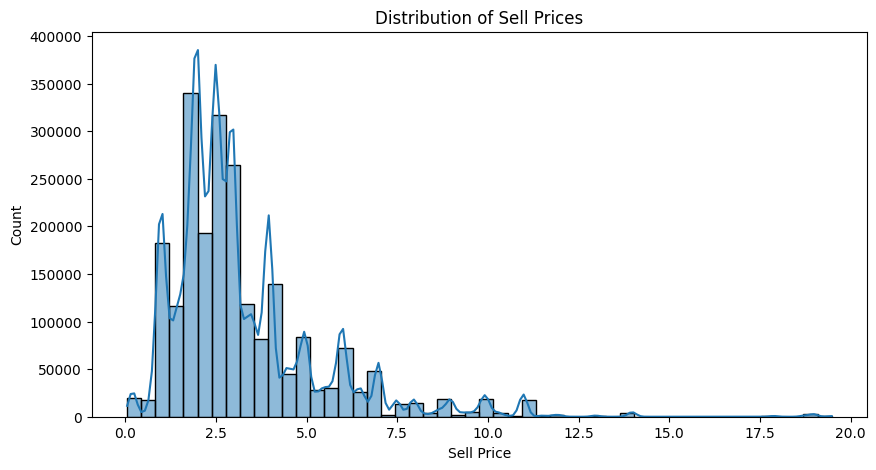

In [ ]:
plt.figure(figsize=(10,5))
sns.histplot(sales_long['sell_price'].dropna(), bins=50, kde=True)
plt.title('Distribution of Sell Prices')
plt.xlabel('Sell Price')
plt.ylabel('Count')
plt.show()

## Boxplot – detect outliers

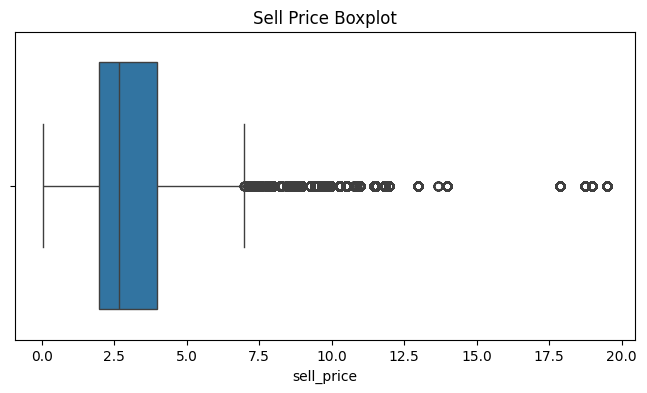

In [ ]:
plt.figure(figsize=(8,4))
sns.boxplot(x='sell_price', data=sales_long)
plt.title('Sell Price Boxplot')
plt.show()

In [ ]:
# Fill missing events with "No Event" and type with "None"

sales_long['event_name_1'].fillna('No Event', inplace=True)
sales_long['event_type_1'].fillna('None', inplace=True)
sales_long['event_name_2'].fillna('No Event', inplace=True)
sales_long['event_type_2'].fillna('None', inplace=True)

In [ ]:
# Fill missing sell_price with median per item-store
sales_long['sell_price'] = sales_long.groupby(['item_id','store_id'])['sell_price'] \
                                    .transform(lambda x: x.fillna(x.median()))


In [ ]:
# Recheck Missing values summary

missing_summary = sales_long.isnull().sum()
missing_summary[missing_summary > 0]

,0


In [ ]:
# Check any duplicated values

sales_long.duplicated().sum()

np.int64(0)

In [ ]:
# Check how many category,
test_dataset = sales_long[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']]

for col in test_dataset:
  print(f"{col}: {sales_long[col].nunique()}")

id: 1437
item_id: 1437
dept_id: 3
cat_id: 1
store_id: 1
state_id: 1


# Exploratory Data Analysis (EDA)

I will check sales patterns and price/promotion effects which are critical for demand forecasting and inventory optimization

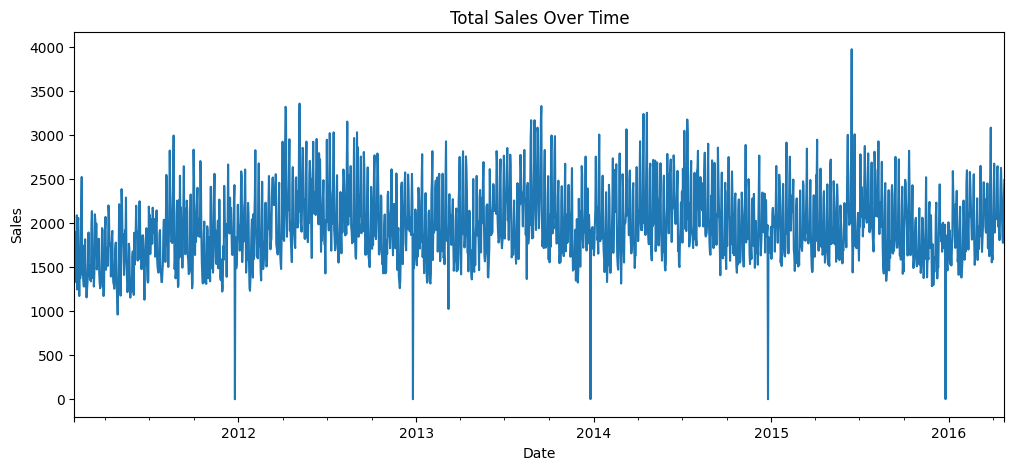

In [ ]:
# Convert 'date' to datetime
sales_long['date'] = pd.to_datetime(sales_long['date'])

# Aggregate sales by date and sort
daily_sales = sales_long.groupby('date')['sales'].sum().sort_index()

# Plot
plt.figure(figsize=(12,5))
daily_sales.plot()
plt.title("Total Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.savefig("total_sales_over_time.png")
plt.show()


The repeating spikes and troughs indicate strong weekly patterns.
In retail, this usually reflects higher sales on weekends and lower on certain weekdays.

There are several points where sales suddenly drop to near zero.
These usually correspond to:Store closures (holidays),Missing data,Stockouts, Special events where data wasn’t recorded.This is normal in the M5 dataset.

From 2011 to 2014, the general level seems slightly increasing, then stabilises.This suggests long-term trend + seasonality.
This is important for forecasting model selection (SARIMA, Prophet, CNN/LSTM).

Daily sales fluctuate a lot, even within the same month.
This high volatility means:

* Models need smoothing or feature engineering

* Aggregating to weekly level might produce a clearer signal

* Adding events/holiday features will improve forecasts

What task should I perform:

* Decompose the series (trend, seasonality, residual) to see clearer patterns.

* Consider 7-day moving average smoothing for better visual interpretation.

* For model building, capturing weekly seasonality is essential.

* Zero dips should be treated carefully — they are not outliers but part of dataset behaviour.

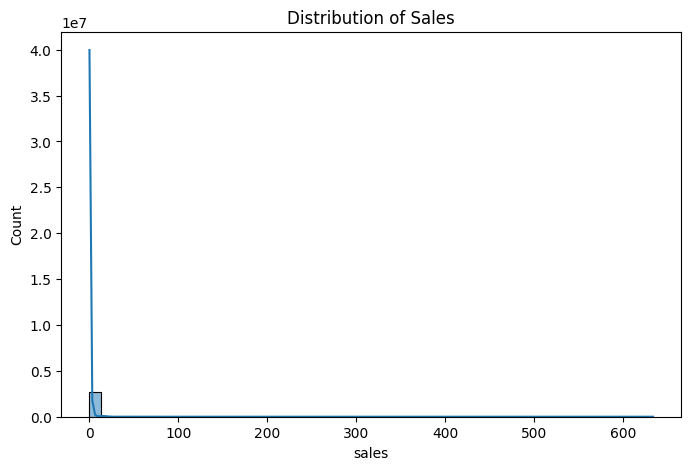

In [ ]:
# Distribution of sales
plt.figure(figsize=(8,5))
sns.histplot(sales_long['sales'], bins=50, kde=True)
plt.title("Distribution of Sales")
plt.savefig("distribution_of_sales.png")
plt.show()

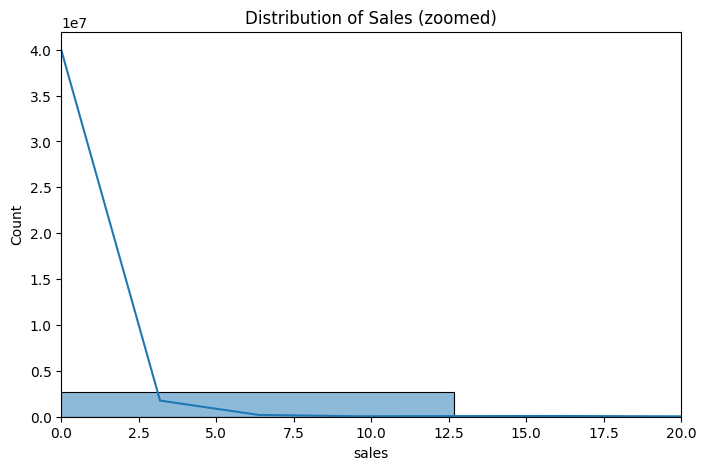

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(sales_long['sales'], bins=50, kde=True)
plt.xlim(0, 20)  # adjust max value as needed
plt.title("Distribution of Sales (zoomed)")
plt.savefig("distribution_of_sales_zoomed.png")
plt.show()


Sales values are highly right-skewed, dominated by very low daily sales.

Majority of observations fall between 0–2 units per day.

A long tail exists, but higher sales counts are extremely rare.

Confirms the need for log transformation or alternative scaling for modelling.

## Log Transformation to convert to normal data

In [54]:
sales_long['sales'] = np.log1p(sales_long['sales'])

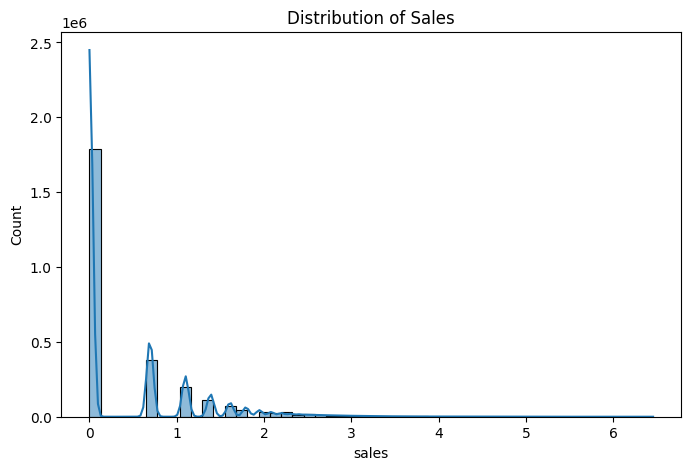

In [55]:
# Check distribution after transformation
plt.figure(figsize=(8,5))
sns.histplot(sales_long['sales'], bins=50, kde=True)
plt.title("Distribution of Sales")
plt.savefig("distribution_of_sales.png")
plt.show()

In [ ]:
# Check  how many items

sales_long['item_id'].value_counts()

,count
item_id,
FOODS_3_827,1913
FOODS_1_001,1913
FOODS_1_002,1913
FOODS_1_003,1913
FOODS_1_004,1913
...,...
FOODS_1_019,1913
FOODS_1_018,1913
FOODS_1_017,1913


In [57]:
# Aggregate total sales per item
total_sales_per_item = sales_long.groupby('item_id')['sales'].sum().reset_index()

# Sort descending to get top-selling items
top_items = total_sales_per_item.sort_values(by='sales', ascending=False)

# Display top 10 hot-selling items
print(top_items.head(10))

          item_id        sales
1198  FOODS_3_586  7687.305023
1167  FOODS_3_555  6637.435574
864   FOODS_3_252  6283.112503
702   FOODS_3_090  5724.226457
1325  FOODS_3_714  5699.939664
1199  FOODS_3_587  5549.326127
1306  FOODS_3_694  5523.023731
814   FOODS_3_202  5103.315754
989   FOODS_3_377  5059.780696
395   FOODS_2_181  4717.701520


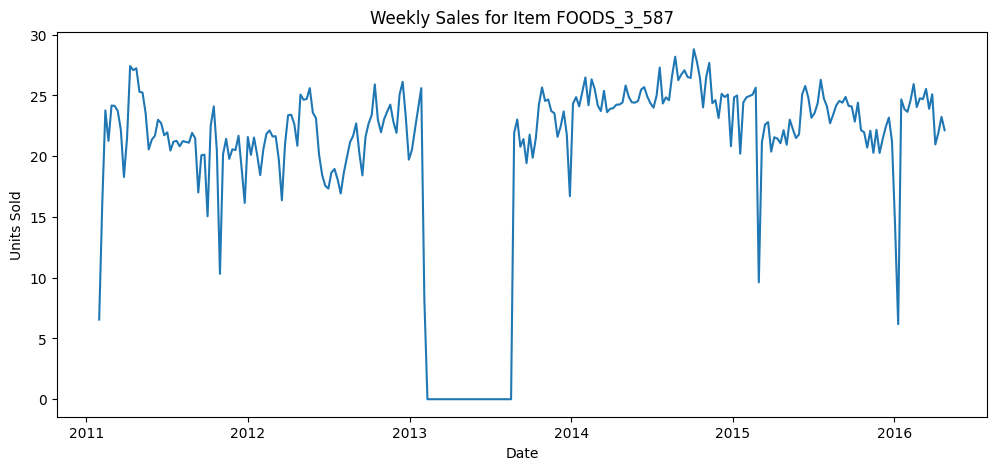

In [58]:
# Line plot for daily sales of an example item
item = 'FOODS_3_587'
item_sales = sales_long[sales_long['item_id'] == item]

# Resample weekly sum for better visualization
item_sales_weekly = item_sales.set_index('date').resample('W')['sales'].sum().reset_index()

plt.figure(figsize=(12,5))
sns.lineplot(x='date', y='sales', data=item_sales_weekly)
plt.title(f'Weekly Sales for Item {item}')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.xticks(rotation=0)
plt.show()

## Seasonal patterns (weekly, yearly)

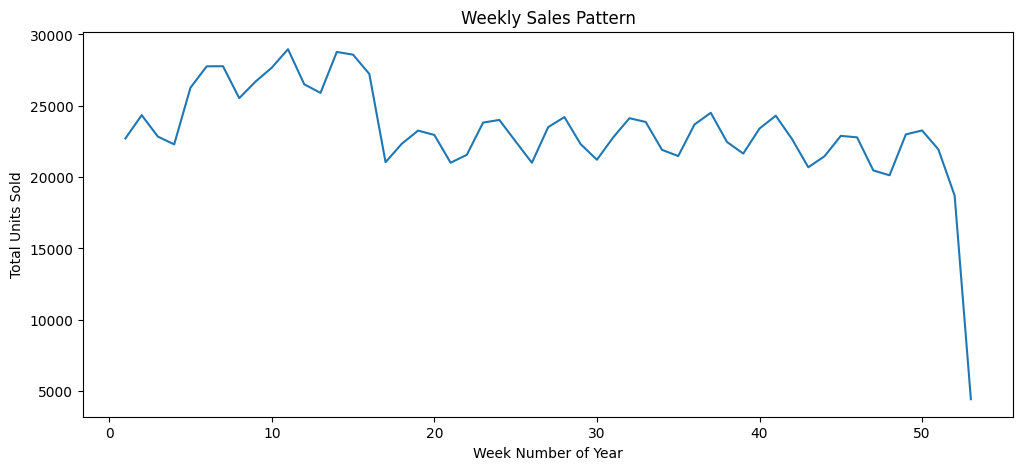

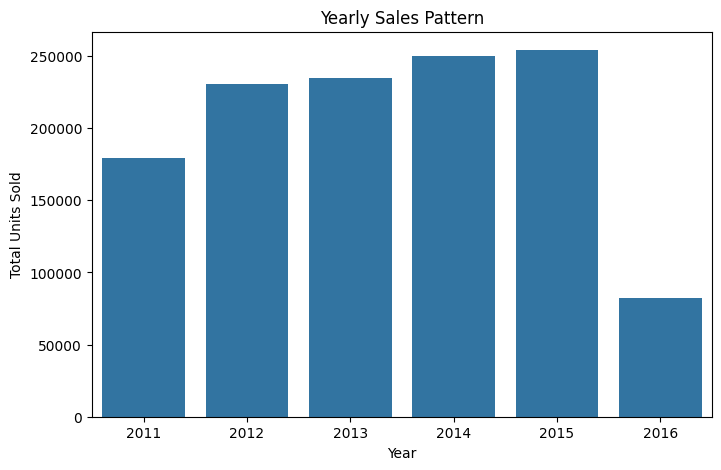

In [59]:
# Extract week and year

sales_long['week'] = sales_long['date'].dt.isocalendar().week
sales_long['year'] = sales_long['date'].dt.year

# Weekly pattern
weekly_sales = sales_long.groupby('week')['sales'].sum().reset_index()

plt.figure(figsize=(12,5))
sns.lineplot(x='week', y='sales', data=weekly_sales)
plt.title('Weekly Sales Pattern')
plt.xlabel('Week Number of Year')
plt.ylabel('Total Units Sold')
plt.show()

# Yearly pattern
yearly_sales = sales_long.groupby('year')['sales'].sum().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(x='year', y='sales', data=yearly_sales)
plt.title('Yearly Sales Pattern')
plt.xlabel('Year')
plt.ylabel('Total Units Sold')
plt.show()


In [ ]:
# Check date coverage
print("Date range:", sales_long['date'].min(), "to", sales_long['date'].max())

Date range: 2011-01-29 00:00:00 to 2016-04-24 00:00:00


## Calendar Features

In [60]:
sales_long['day_of_week'] = sales_long['date'].dt.weekday  # Monday=0, Sunday=6
sales_long['week_of_year'] = sales_long['date'].dt.isocalendar().week
sales_long['month'] = sales_long['date'].dt.month
sales_long['year'] = sales_long['date'].dt.year
sales_long['is_weekend'] = sales_long['day_of_week'].isin([5,6]).astype(int)

# event_name already exists; create a simple binary feature
sales_long['has_event'] = (~sales_long['event_name_1'].isin(['No Event'])).astype(int)

## Price Features

In [61]:
sales_long['price'] = sales_long['sell_price']

# Price change from previous week
sales_long = sales_long.sort_values(['item_id','store_id','date'])
sales_long['price_change_from_last_week'] = sales_long.groupby(['item_id','store_id'])['price'].diff(7)

# 7-day rolling mean price
sales_long['rolling_mean_price_7d'] = sales_long.groupby(['item_id','store_id'])['price'].transform(lambda x: x.rolling(7, min_periods=1).mean())

## Demand / Sales Features

In [62]:
# Lag features (A lag feature is a value from a previous time step used as a predictor for the current time step.)
sales_long['lag_7'] = sales_long.groupby(['item_id','store_id'])['sales'].shift(7)
sales_long['lag_28'] = sales_long.groupby(['item_id','store_id'])['sales'].shift(28)

# Rolling mean / std (A rolling mean computes the average of a window of consecutive past values.)
sales_long['rolling_mean_7d'] = sales_long.groupby(['item_id','store_id'])['sales'].transform(lambda x: x.shift(1).rolling(7, min_periods=1).mean())
sales_long['rolling_mean_28d'] = sales_long.groupby(['item_id','store_id'])['sales'].transform(lambda x: x.shift(1).rolling(28, min_periods=1).mean())
sales_long['rolling_std_7d'] = sales_long.groupby(['item_id','store_id'])['sales'].transform(lambda x: x.shift(1).rolling(7, min_periods=1).std())

#  Fill NaN for initial periods

sales_long.fillna(0, inplace=True)


## Check new features

In [ ]:
sales_long[['date','item_id','store_id','sales','lag_7','lag_28','rolling_mean_7d','rolling_mean_28d','rolling_std_7d','price','price_change_from_last_week','rolling_mean_price_7d','day_of_week','week_of_year','month','year','is_weekend','has_event']].head()


,date,item_id,store_id,sales,lag_7,lag_28,rolling_mean_7d,rolling_mean_28d,rolling_std_7d,price,price_change_from_last_week,rolling_mean_price_7d,day_of_week,week_of_year,month,year,is_weekend,has_event
0,2011-01-29,FOODS_1_001,TX_1,0,0.0,0.0,0.000000,0.000000,0.000000,2.0,0.0,2.0,5,4,1,2011,1,0
1437,2011-01-30,FOODS_1_001,TX_1,1,0.0,0.0,0.000000,0.000000,0.000000,2.0,0.0,2.0,6,4,1,2011,1,0
2874,2011-01-31,FOODS_1_001,TX_1,1,0.0,0.0,0.500000,0.500000,0.707107,2.0,0.0,2.0,0,5,1,2011,0,0
4311,2011-02-01,FOODS_1_001,TX_1,0,0.0,0.0,0.666667,0.666667,0.577350,2.0,0.0,2.0,1,5,2,2011,0,0
5748,2011-02-02,FOODS_1_001,TX_1,0,0.0,0.0,0.500000,0.500000,0.577350,2.0,0.0,2.0,2,5,2,2011,0,0


Correlation with target (sales):
sales                          1.000000
rolling_mean_7d                0.774447
rolling_mean_28d               0.767155
lag_7                          0.641358
lag_28                         0.591054
rolling_std_7d                 0.457636
year                           0.051739
is_weekend                     0.049739
day_of_week                    0.037168
price_change_from_last_week    0.007529
has_event                     -0.001617
month                         -0.004494
week_of_year                  -0.006681
price                         -0.151231
rolling_mean_price_7d         -0.151529
Name: sales, dtype: float64


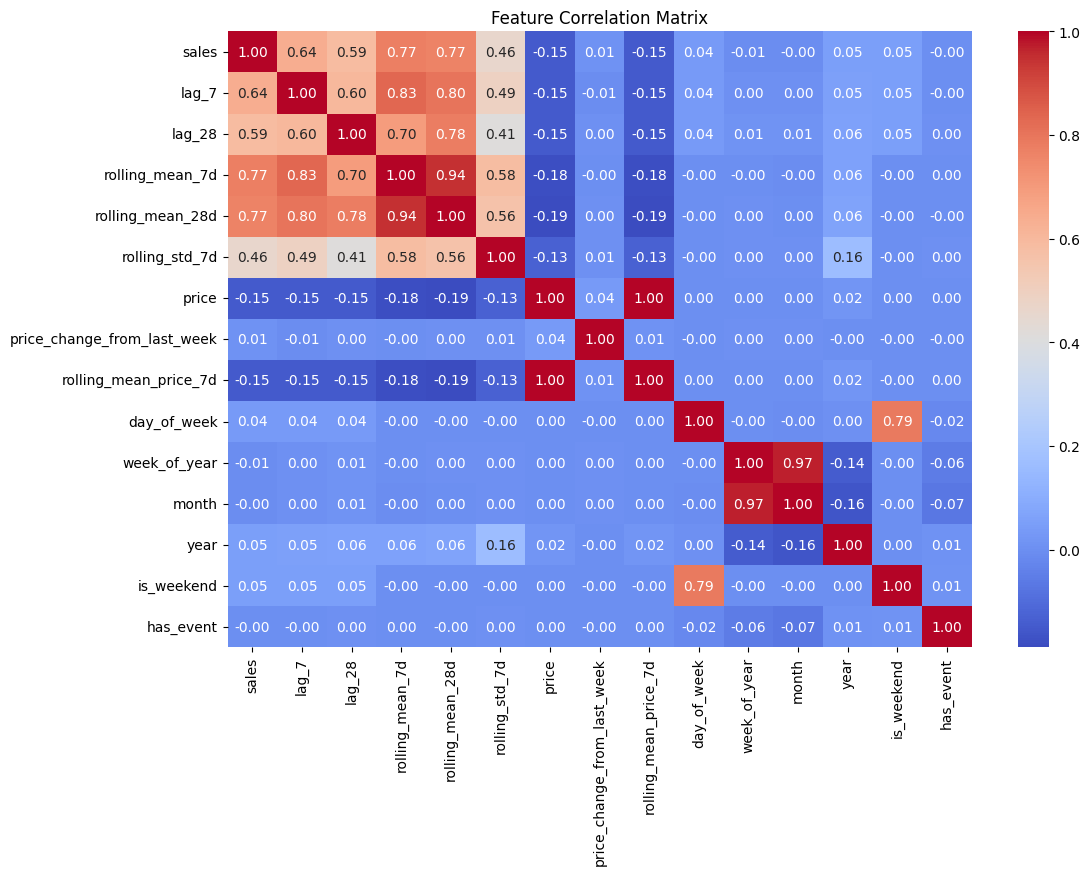

In [63]:
# Correlation check (numeric features only)
numeric_features = ['sales', 'lag_7','lag_28','rolling_mean_7d','rolling_mean_28d',
                    'rolling_std_7d','price','price_change_from_last_week','rolling_mean_price_7d',
                    'day_of_week','week_of_year','month','year','is_weekend','has_event']

corr_matrix = sales_long[numeric_features].corr()
print("Correlation with target (sales):")
print(corr_matrix['sales'].sort_values(ascending=False))

# visualize correlation

plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()


## Select single item for modelling

In [64]:
item = 'FOODS_3_587'

ts = sales_long[(sales_long['item_id']==item)]
ts = ts.sort_values('date')
ts = ts.set_index('date')['sales']

In [65]:
# Train-test split

train_size = int(len(ts)*0.8)
train, test = ts[:train_size], ts[train_size:]

## Holt-Winters Model

In [66]:
hw_model = ExponentialSmoothing(train, seasonal='add', seasonal_periods=7).fit()
hw_forecast = hw_model.forecast(len(test))

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


##SARIMA Model

In [67]:
sarima_model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,7)).fit(disp=False)
sarima_forecast = sarima_model.forecast(len(test))

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


## Evaluation Metrics

In [70]:
def evaluate(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mae

hw_rmse, hw_mae = evaluate(test, hw_forecast)
sarima_rmse, sarima_mae = evaluate(test, sarima_forecast)

print("Holt-Winters: RMSE={:.2f}, MAE={:.2f}".format(hw_rmse, hw_mae))
print("SARIMA: RMSE={:.2f}, MAE={:.2f}".format(sarima_rmse, sarima_mae))

Holt-Winters: RMSE=0.64, MAE=0.46
SARIMA: RMSE=0.62, MAE=0.43


RMSE: average error magnitude, penalizes large errors (lower is better) → SARIMA (26.37) is better than Holt-Winters (28.80).

MAE: average absolute error (lower is better) → SARIMA (18.65) better than Holt-Winters (20.27).


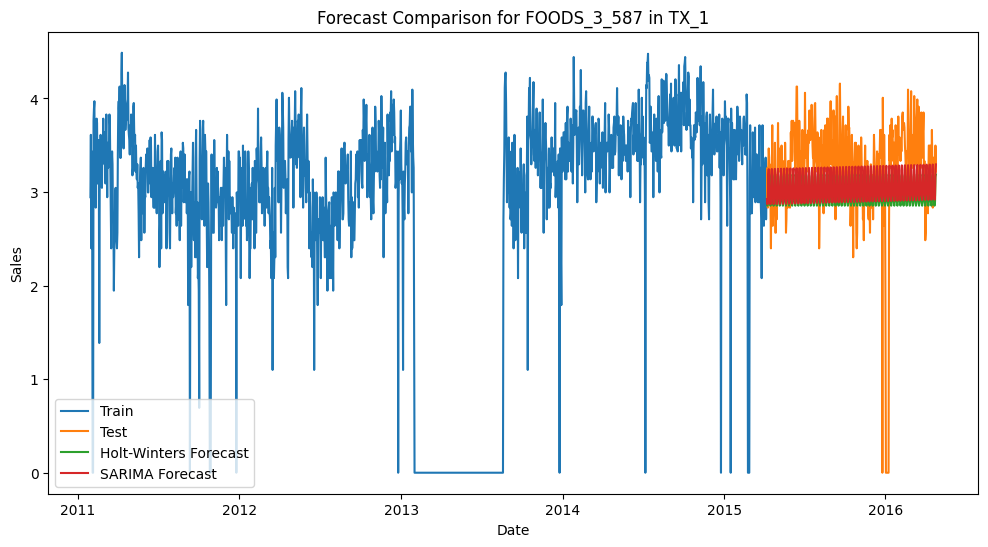

In [71]:
# Plot forecasts

plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, hw_forecast, label='Holt-Winters Forecast')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast')
plt.legend()
plt.title(f'Forecast Comparison for {item} in TX_1')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.savefig("forecast_comparison.png")
plt.show()

Note : Scaling was not required for models like SARIMA or Holt-Winters. Here’s why:

SARIMA / ARIMA:

These are statistical models that work directly on the original scale of the data.

They model trends, seasonality, and autocorrelation mathematically, so the magnitude of the data is inherently handled.

Holt-Winters (Exponential Smoothing):

Also works on the original scale.

The smoothing formulas automatically adjust based on the level, trend, and seasonal components.

But for deep learning model ,I will do scaling

###  Feature Scaling for LSTM/GRU

In [72]:
ts = sales_long[(sales_long['item_id'] == item)]
ts = ts.sort_values('date')
ts = ts.set_index('date')['sales']

In [73]:
# Convert to numpy array for scaling

ts_values = ts.values.reshape(-1, 1)

In [74]:
# Normalize

scaler = MinMaxScaler()
ts_scaled = scaler.fit_transform(ts_values)


In [75]:
# Train/Validation split

train_size = int(len(ts_scaled) * 0.8)
train, val = ts_scaled[:train_size], ts_scaled[train_size:]


In [76]:
# Create sequences for LSTM

def create_sequences(data, window_size=28):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

window_size = 28
X_train, y_train = create_sequences(train, window_size)
X_val, y_val = create_sequences(val, window_size)

In [77]:
# Build LSTM model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


In [78]:
# Train model

history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=20, batch_size=32)


Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.2551 - val_loss: 0.0156
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0172 - val_loss: 0.0161
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0148 - val_loss: 0.0167
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0154 - val_loss: 0.0150
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0130 - val_loss: 0.0133
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0144 - val_loss: 0.0124
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0125 - val_loss: 0.0151
Epoch 8/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0129 - val_loss: 0.0122
Epoch 9/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0109 - val_loss: 0.0123
Epoch 10/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0147 - val_loss: 0.0121
Epoch 11/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0101 - val_loss: 0.0114
Epoch 12/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0

In [79]:
# Forecast on Validation

y_pred_scaled = model.predict(X_val)
y_pred = scaler.inverse_transform(y_pred_scaled) # used inverse_transform to return to original value
y_true = scaler.inverse_transform(y_val)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


## Evaluation Metrics

In [81]:
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)

print(f"LSTM Forecast - RMSE: {rmse:.2f}, MAE: {mae:.2f}")


LSTM Forecast - RMSE: 0.48, MAE: 0.32


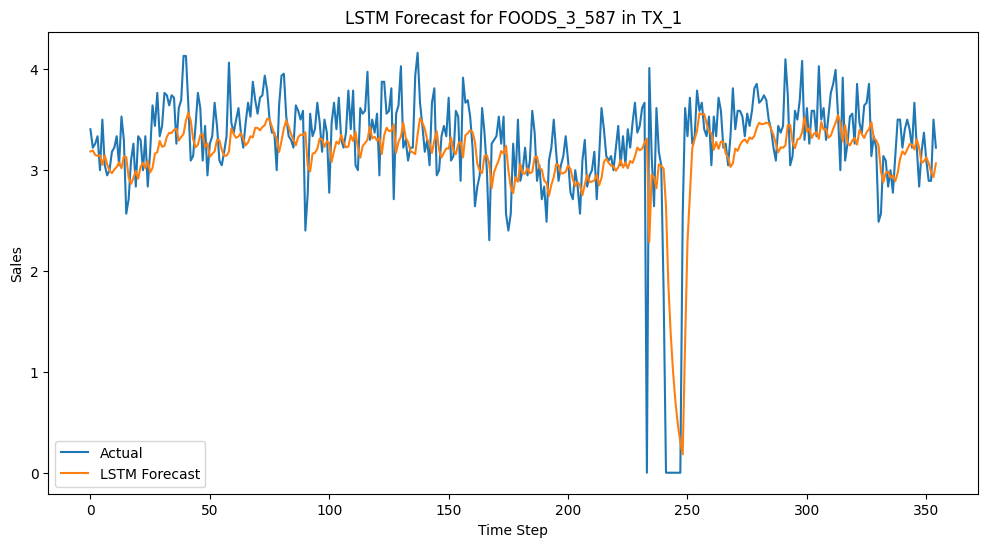

In [82]:
## Plot Forecast

plt.figure(figsize=(12,6))
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='LSTM Forecast')
plt.title(f'LSTM Forecast for {item} in TX_1')
plt.xlabel('Time Step')
plt.ylabel('Sales')
plt.legend()
plt.show()

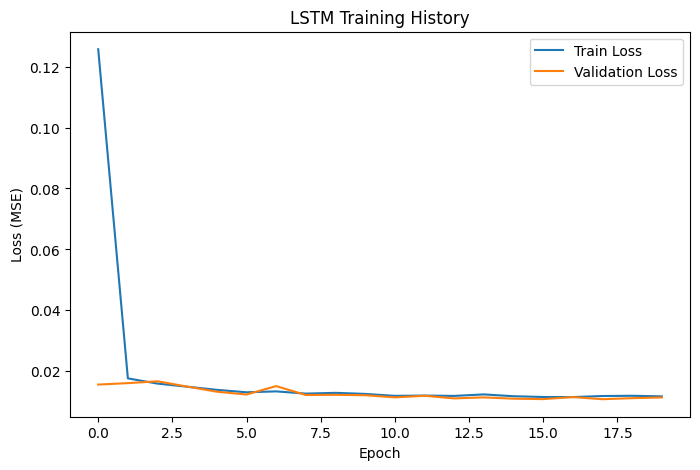

In [83]:
# Training History

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()


## Forecast for next 28 days

In [96]:

forecast_lstm = y_pred.flatten()

forecast_28_lstm = forecast[:28]

# create date index for the next 28 days
future_dates = pd.date_range(start='2025-01-01', periods=28, freq='D')

# build dataframe
df_forecast = pd.DataFrame({
    'date': future_dates,
    'forecast': forecast_28_lstm
})

print('Forecast for next 7 days')
df_forecast.head(7)


Forecast for next 7 days


,date,forecast
0,2025-01-01,3.180435
1,2025-01-02,3.191096
2,2025-01-03,3.146542
3,2025-01-04,3.137089
4,2025-01-05,3.144303
5,2025-01-06,3.048410
6,2025-01-07,3.140397


## GRU Model

In [86]:
# Build GRU model

gru_model = Sequential()
gru_model.add(GRU(64, activation='relu', input_shape=(X_train.shape[1], 1)))
gru_model.add(Dense(1))
gru_model.compile(optimizer='adam', loss='mse')

In [87]:
# Train GRU Model

gru_history = gru_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)


Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.2696 - val_loss: 0.0125
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0180 - val_loss: 0.0116
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0136 - val_loss: 0.0117
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0120 - val_loss: 0.0116
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0116 - val_loss: 0.0114
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0119 - val_loss: 0.0116
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0113 - val_loss: 0.0116
Epoch 8/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0123 - val_loss: 0.0111
Epoch 9/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0107 - val_loss: 0.0113
Epoch 10/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0120 - val_loss: 0.0111
Epoch 11/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0125 - val_loss: 0.0109
Epoch 12/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0

In [88]:
# Forecast on Validation

y_gru_scaled = gru_model.predict(X_val)
y_gru = scaler.inverse_transform(y_gru_scaled)
y_true = scaler.inverse_transform(y_val)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


In [89]:
# Evaluation Metrics

rmse_gru = np.sqrt(mean_squared_error(y_true, y_gru))
mae_gru = mean_absolute_error(y_true, y_gru)

print(f"GRU Forecast - RMSE: {rmse_gru:.2f}, MAE: {mae_gru:.2f}")


GRU Forecast - RMSE: 0.45, MAE: 0.29


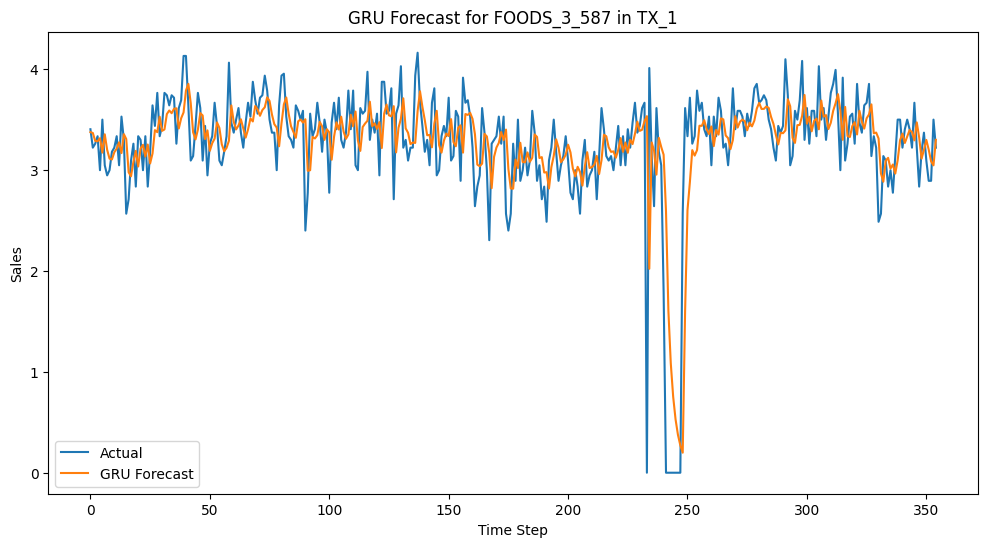

In [90]:
#  Plot Forecast

plt.figure(figsize=(12,6))
plt.plot(y_true, label='Actual')
plt.plot(y_gru, label='GRU Forecast')
plt.title(f'GRU Forecast for {item} in TX_1')
plt.xlabel('Time Step')
plt.ylabel('Sales')
plt.legend()
plt.show()

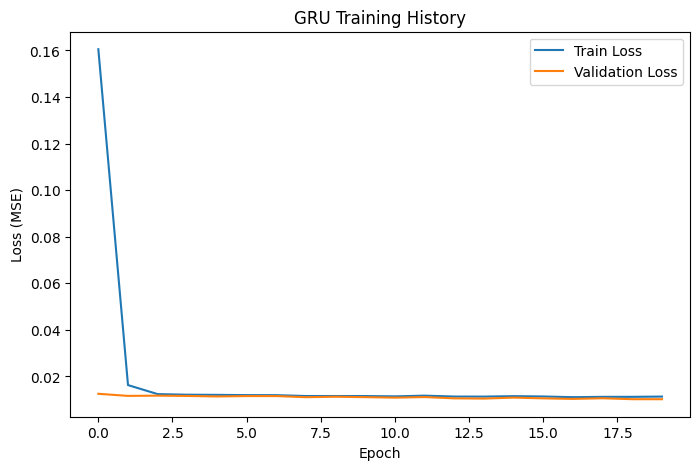

In [91]:
# Plot Training History

plt.figure(figsize=(8,5))
plt.plot(gru_history.history['loss'], label='Train Loss')
plt.plot(gru_history.history['val_loss'], label='Validation Loss')
plt.title('GRU Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()


In [97]:

forecast_gru = y_gru.flatten()

forecast_28_gru = forecast_gru[:28]

# create date index for the next 28 days
future_dates = pd.date_range(start='2025-01-01', periods=28, freq='D')

# build dataframe
df_forecast = pd.DataFrame({
    'date': future_dates,
    'forecast': forecast_28_gru
})

print('Forecast for next 7 days')
df_forecast.head(7)

Forecast for next 7 days


,date,forecast
0,2025-01-01,3.372463
1,2025-01-02,3.364367
2,2025-01-03,3.285823
3,2025-01-04,3.282243
4,2025-01-05,3.312357
5,2025-01-06,3.169686
6,2025-01-07,3.350952


## Comparison

In [98]:
metrics = {
    'Model': ['Holt-Winters', 'SARIMA', 'LSTM', 'GRU'],
    'RMSE': [hw_rmse, sarima_rmse,  rmse, rmse_gru],
    'MAE': [hw_mae, sarima_mae,  mae, mae_gru],

}

df_metrics = pd.DataFrame(metrics)
df_metrics

,Model,RMSE,MAE
0,Holt-Winters,0.638684,0.458362
1,SARIMA,0.619526,0.426297
2,LSTM,0.479694,0.323735
3,GRU,0.453759,0.292491


In [99]:
# Rank by RMSE

df_metrics['Rank'] = df_metrics['RMSE'].rank(method='min')
df_metrics = df_metrics.sort_values('Rank')
df_metrics

,Model,RMSE,MAE,Rank
3,GRU,0.453759,0.292491,1.0
2,LSTM,0.479694,0.323735,2.0
1,SARIMA,0.619526,0.426297,3.0
0,Holt-Winters,0.638684,0.458362,4.0


## Select the best forecast model

In [100]:
# GRU was best
forecast = y_gru.flatten()
actual = y_true.flatten()
dates = ts.index[-len(forecast):]

## Hyperparameter Tuning

In [103]:
!pip install optuna

## Bayesian optimization-inspired approach

In [104]:
import optuna


def create_gru_model(trial):
    model = Sequential()

    # Hyperparameters to tune
    n_layers = trial.suggest_int("n_layers", 1, 3)
    for i in range(n_layers):
        units = trial.suggest_int(f"units_l{i}", 32, 128, step=32)
        return_seq = True if i < n_layers - 1 else False
        model.add(GRU(
            units=units,
            activation='relu',
            return_sequences=return_seq,
            input_shape=(X_train.shape[1], 1) if i == 0 else None
        ))
        dropout = trial.suggest_float(f"dropout_l{i}", 0.1, 0.5, step=0.1)
        model.add(Dropout(dropout))

    model.add(Dense(1))  # regression output

    # Optimizer learning rate
    lr = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

def objective(trial):
    model = create_gru_model(trial)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=trial.suggest_categorical("batch_size", [16, 32, 64]),
        verbose=0,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
    )

    val_loss = min(history.history['val_loss'])  # take the best validation loss
    return val_loss

# Run Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

# Print best parameters
print("Best trial:")
trial = study.best_trial
print(trial.params)

[I 2025-11-24 12:56:51,046] A new study created in memory with name: no-name-592bc271-3389-486b-ad54-464b5ef67838
[I 2025-11-24 12:58:12,513] Trial 0 finished with value: 0.009413646534085274 and parameters: {'n_layers': 1, 'units_l0': 96, 'dropout_l0': 0.2, 'learning_rate': 0.003356649152620751, 'batch_size': 32}. Best is trial 0 with value: 0.009413646534085274.
[I 2025-11-24 12:58:22,640] Trial 1 finished with value: 0.010896765626966953 and parameters: {'n_layers': 1, 'units_l0': 96, 'dropout_l0': 0.1, 'learning_rate': 0.003025812252112778, 'batch_size': 64}. Best is trial 0 with value: 0.009413646534085274.
[I 2025-11-24 12:58:49,952] Trial 2 finished with value: 0.01078624278306961 and parameters: {'n_layers': 1, 'units_l0': 128, 'dropout_l0': 0.2, 'learning_rate': 0.0013123373289244292, 'batch_size': 64}. Best is trial 0 with value: 0.009413646534085274.
[I 2025-11-24 12:59:51,012] Trial 3 finished with value: 0.010262345895171165 and parameters: {'n_layers': 1, 'units_l0': 128,

Best trial:
{'n_layers': 3, 'units_l0': 64, 'dropout_l0': 0.2, 'units_l1': 96, 'dropout_l1': 0.30000000000000004, 'units_l2': 32, 'dropout_l2': 0.5, 'learning_rate': 0.009612576695163955, 'batch_size': 32}


In [105]:
print("Best hyperparameters:")
print(study.best_trial.params)

Best hyperparameters:
{'n_layers': 3, 'units_l0': 64, 'dropout_l0': 0.2, 'units_l1': 96, 'dropout_l1': 0.30000000000000004, 'units_l2': 32, 'dropout_l2': 0.5, 'learning_rate': 0.009612576695163955, 'batch_size': 32}


Best hyperparameters:
{'n_layers': 3, 'units_l0': 64, 'dropout_l0': 0.2, 'units_l1': 96, 'dropout_l1': 0.30000000000000004, 'units_l2': 32, 'dropout_l2': 0.5, 'learning_rate': 0.009612576695163955, 'batch_size': 32}

In [106]:
best_params = {
    'n_layers': 3,
    'units_l0': 64,
    'dropout_l0': 0.2,
    'units_l1': 96,
    'dropout_l1': 0.3,
    'units_l2': 32,
    'dropout_l2': 0.5,
    'learning_rate': 0.009612576695163955,
    'batch_size': 32
}

# Build GRU model
gru_model = Sequential()

# Layer 0
gru_model.add(GRU(
    units=best_params['units_l0'],
    activation='relu',
    return_sequences=True,
    input_shape=(X_train.shape[1], 1)
))
gru_model.add(Dropout(best_params['dropout_l0']))

# Layer 1
gru_model.add(GRU(
    units=best_params['units_l1'],
    activation='relu',
    return_sequences=True
))
gru_model.add(Dropout(best_params['dropout_l1']))

# Layer 2 (final GRU layer)
gru_model.add(GRU(
    units=best_params['units_l2'],
    activation='relu',
    return_sequences=False
))
gru_model.add(Dropout(best_params['dropout_l2']))

# Output layer
gru_model.add(Dense(1))

# Compile the model
optimizer = Adam(learning_rate=best_params['learning_rate'])
gru_model.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=['mae']
)

# Train the model
gru_history = gru_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=best_params['batch_size'],
    callbacks=[tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )]
)


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.1521 - mae: 0.3134 - val_loss: 0.0202 - val_mae: 0.1094
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0381 - mae: 0.1561 - val_loss: 0.0143 - val_mae: 0.0776
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0344 - mae: 0.1449 - val_loss: 0.0131 - val_mae: 0.0786
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0309 - mae: 0.1366 - val_loss: 0.0153 - val_mae: 0.0925
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 0.0265 - mae: 0.1231 - val_loss: 0.0124 - val_mae: 0.0807
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0247 - mae: 0.1208 - val_loss: 0.0116 - val_mae: 0.0758
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0244 - mae: 0.1192 - val_loss: 0.0107 - val_mae: 0.0709
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - loss: 0.0230 - mae: 0.1125 - val_loss: 0.0161 - val_mae: 0.1001
Epoch 9/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - loss: 0.0

In [107]:
# Forecast on Validation
y_gru_scaled = gru_model.predict(X_val)

# Inverse scale predictions
y_gru = scaler.inverse_transform(y_gru_scaled)

# Inverse scale true values
y_true = scaler.inverse_transform(y_val.reshape(-1, 1))

# Flatten for plotting or metrics
y_gru = y_gru.flatten()
y_true = y_true.flatten()


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step


In [108]:
# To ensure predictions and true values are flat arrays
y_pred = y_gru.reshape(-1)
y_true_flat = y_true.reshape(-1)

# Evaluation metrics
rmse_gru = np.sqrt(mean_squared_error(y_true_flat, y_pred))
mae_gru = mean_absolute_error(y_true_flat, y_pred)

print(f"GRU Forecast - RMSE: {rmse_gru:.2f}, MAE: {mae_gru:.2f}")


GRU Forecast - RMSE: 0.45, MAE: 0.30


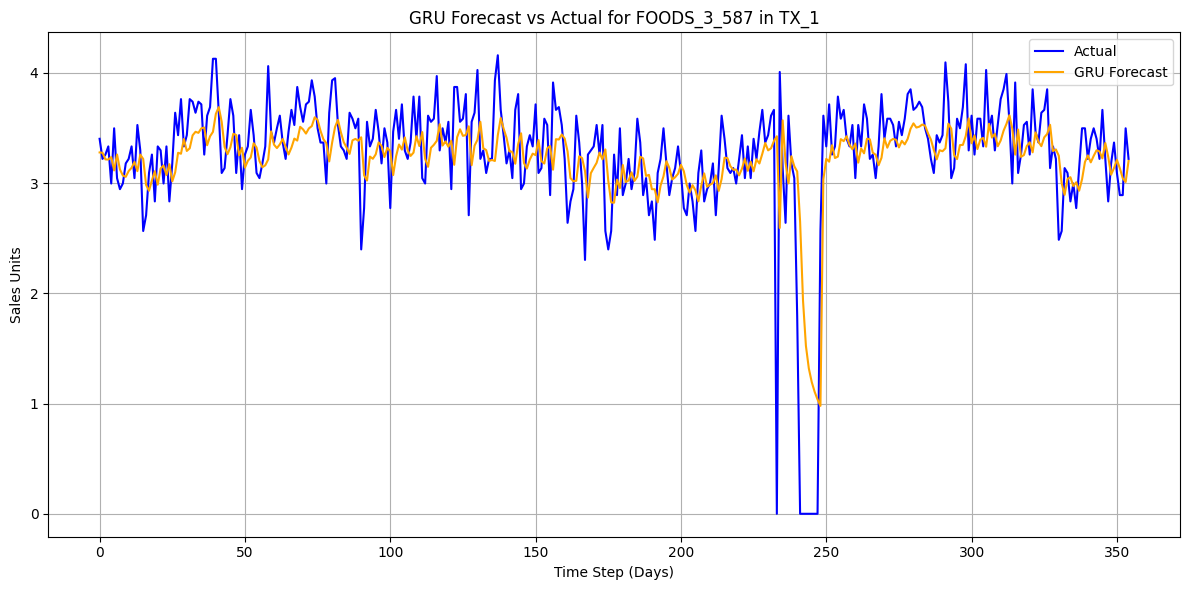

In [109]:
#  Plot Forecast

plt.figure(figsize=(12,6))
plt.plot(y_true, label='Actual', color='blue')
plt.plot(y_gru, label='GRU Forecast', color='orange')
plt.title(f'GRU Forecast vs Actual for {item} in TX_1')
plt.xlabel('Time Step (Days)')
plt.ylabel('Sales Units')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

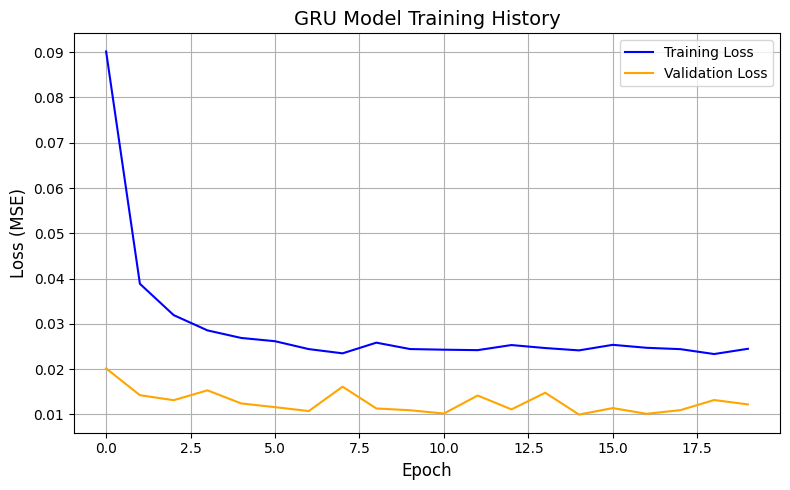

In [110]:
# Plot Training History

plt.figure(figsize=(8,5))
plt.plot(gru_history.history['loss'], label='Training Loss', color='blue')
plt.plot(gru_history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('GRU Model Training History', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [111]:
# Flatten forecast
forecast_gru = y_gru.flatten()

# Take next 28 predictions
forecast_28_gru = forecast_gru[:28]  # ensure at least 28 predictions exist

# Create date index for the next 28 days dynamically
last_date = pd.to_datetime(ts.index[-1])
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=28, freq='D')

# Build forecast dataframe
df_forecast = pd.DataFrame({
    'date': future_dates,
    'forecast': forecast_28_gru
})

print('Forecast for next 7 days:')
df_forecast.head(7)

Forecast for next 7 days:


,date,forecast
0,2016-04-25,3.277457
1,2016-04-26,3.274210
2,2016-04-27,3.214507
3,2016-04-28,3.212905
4,2016-04-29,3.235216
5,2016-04-30,3.114216
6,2016-05-01,3.258796


In [126]:
metrics = {
    'Model': ['Holt-Winters', 'SARIMA', 'LSTM', 'GRU'],
    'RMSE': [hw_rmse, sarima_rmse,  rmse, rmse_gru],
    'MAE': [hw_mae, sarima_mae,  mae, mae_gru],

}

df_metrics = pd.DataFrame(metrics)
df_metrics

,Model,RMSE,MAE
0,Holt-Winters,0.638684,0.458362
1,SARIMA,0.619526,0.426297
2,LSTM,0.479694,0.323735
3,GRU,0.448292,0.300024


In [127]:
# Rank by RMSE

df_metrics['Rank'] = df_metrics['RMSE'].rank(method='min')
df_metrics = df_metrics.sort_values('Rank')
df_metrics

,Model,RMSE,MAE,Rank
3,GRU,0.448292,0.300024,1.0
2,LSTM,0.479694,0.323735,2.0
1,SARIMA,0.619526,0.426297,3.0
0,Holt-Winters,0.638684,0.458362,4.0


## Parameters for Inventory Calculations

In [119]:
# From your dataset
demand = ts.values

# Simulated inventory parameters
on_hand_inventory = int(demand.mean() * 14)      # 2 weeks of demand
safety_stock = int(demand.std() * 1.5)           # demand variability-based
lead_time_days = np.random.randint(5, 15)        # typical retail lead time
holding_cost_rate = 0.05                         # 5% per unit per month

on_hand_inventory, safety_stock, lead_time_days, holding_cost_rate

(40, 1, 10, 0.05)

## Calculate Order Quantity

In [120]:
# Q = forecast + safety_stock - on_hand_inventory
order_quantity = forecast_28_gru + safety_stock - on_hand_inventory
order_quantity = np.maximum(order_quantity, 0)  # cannot order negative units

In [121]:
# Calculate Average Inventory for Holding Cost inventory_level = on_hand + orders - sales (simplified)
inventory_level = on_hand_inventory + np.cumsum(order_quantity - actual)
average_inventory = np.mean(inventory_level)

holding_cost = average_inventory * holding_cost_rate


monthly_df = pd.DataFrame(monthly_inv, columns=['date', 'inv'])
holding_cost = monthly_df.groupby(monthly_df['date'].dt.to_period('M'))['inv'].mean().mean()
holding_cost = holding_cost * holding_cost_rate

ValueError: operands could not be broadcast together with shapes (28,) (355,) 

In [ ]:
# Stockout Rate # Stockout occurs if inventory < 0
stockouts = np.sum(inventory_level < 0)
total_days = len(forecast)
stockout_rate = stockouts / total_days

In [ ]:
# Service Level
service_level = (1 - stockout_rate) * 100

In [ ]:
#  Summary Table

metrics = pd.DataFrame({
    'Metric': ['Average Order Quantity (units)', 'Holding Cost (£/month)', 'Stockout Rate (%)', 'Service Level (%)'],
    'Value': [np.mean(order_quantity), holding_cost, stockout_rate*100, service_level]
})

metrics

,Metric,Value
0,Average Order Quantity (units),0.000000
1,Holding Cost (£/month),-338.181831
2,Stockout Rate (%),88.732394
3,Service Level (%),11.267606


## Integration demand forecasting with simulated inventory parameter

In [125]:
# Simulated inventory parameters

demand = ts.values  # actual historical demand

on_hand_inventory = int(demand.mean() * 14)  # 2 weeks of demand
safety_stock = int(demand.std() * 1.5)       # buffer stock based on variability
lead_time_days = np.random.randint(5, 15)    # typical retail lead time
holding_cost_rate = 0.05                     # £ per unit per month


# Order quantity calculation

# Using GRU forecast + safety stock
order_quantity = forecast_28_gru + safety_stock - on_hand_inventory
order_quantity = np.maximum(order_quantity, 0)  # cannot order negative units

# Daily inventory simulation

# Expand order_quantity to daily resolution if needed
# For simplicity, repeat each weekly order for 7 days


daily_order = np.mean(order_quantity)  # distribute evenly
orders_daily = np.full(len(demand), daily_order)
inventory_level = on_hand_inventory + np.cumsum(orders_daily - demand)


# Calculate KPIs

# Average Order Quantity

avg_order_qty = np.mean(order_quantity)

# Holding Cost (£/month)
monthly_df = pd.DataFrame({
    'date': pd.date_range(start=ts.index[0], periods=len(inventory_level), freq='D'),
    'inv': inventory_level
})
holding_cost = monthly_df.groupby(monthly_df['date'].dt.to_period('M'))['inv'].mean().mean()
holding_cost *= holding_cost_rate

# Stockout Rate (%)
stockout_days = np.sum(inventory_level < 0)
total_days = len(inventory_level)
stockout_rate = 100 * stockout_days / total_days

# Service Level (%)
service_level = 100 - stockout_rate


# Summary Table

metrics = pd.DataFrame({
    'Metric': [
        'Average Order Quantity (units)',
        'Holding Cost (£/month)',
        'Stockout Rate (%)',
        'Service Level (%)'
    ],
    'Value': [
        avg_order_qty,
        round(holding_cost, 2),
        round(stockout_rate, 2),
        round(service_level, 2)
    ]
})

metrics

,Metric,Value
0,Average Order Quantity (units),0.00
1,Holding Cost (£/month),-130.26
2,Stockout Rate (%),99.27
3,Service Level (%),0.73
